In [1]:
import pandas as pd
import numpy as np
import cv2
import glob
import time
from random import shuffle
from collections import deque
from scipy.ndimage.measurements import label

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            hog_features = []
            yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            hog_features.append(get_hog_features(yuv_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features.append(get_hog_features(yuv_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            hog_features.append(get_hog_features(hsv_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features.append(get_hog_features(hsv_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features) 
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
def get_random_car_and_non_car(rand_num = 10):
    non_car_loc = ".\\non-vehicles\\non-vehicles\\*\\*.png"
    car_loc = ".\\vehicles\\vehicles\\*\\*.png"
    cars = [i for i in glob.glob(car_loc)]
    notcars = [i for i in glob.glob(non_car_loc)]
    return plt.imread(cars[10]),plt.imread(notcars[10])

def get_model():
    ## read the images and extract the features
    non_car_loc = ".\\non-vehicles\\non-vehicles\\*\\*.png"
    car_loc = ".\\vehicles\\vehicles\\*\\*.png"
    cars = [i for i in glob.glob(car_loc)]
    notcars = [i for i in glob.glob(non_car_loc)]

    ## shuffle the images 
    shuffle(cars)
    shuffle(notcars)

    ## param settings
    color_space = 'RGB' ##remove when cleaning
    orient = 8  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [None, None] # Min and max in y to search in slide_window()

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    X_train, X_test, y_train, y_test = train_test_split( scaled_X, y, test_size=0.2, random_state= np.random.randint(0, 100))
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    return svc, X_scaler,round(svc.score(X_test, y_test), 4)

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def nvl(x, default):
    if x == None:
        return default
    return x
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    x_start_stop[0] = nvl(x_start_stop[0], 0)
    x_start_stop[1] = nvl(x_start_stop[1], img.shape[1])
    y_start_stop[0] = nvl(y_start_stop[0], 0)
    y_start_stop[1] = nvl(y_start_stop[1], img.shape[0])
    
    window_list = []
    x_start = x_start_stop[0]
    while x_start < x_start_stop[1]:
        if x_start + xy_window[0] > x_start_stop[1]:
            break
        y_start = y_start_stop[0]
        while y_start  < y_start_stop[1]:
            if y_start + xy_window[1] > y_start_stop[1]:
                break
            window_list.append(((x_start, y_start), (x_start + xy_window[0], y_start + xy_window[1])))
            y_start = y_start + int(xy_window[1]* xy_overlap[1])
        x_start = x_start + int(xy_window[0]* xy_overlap[0])
        
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        hog_features = []
        yuv_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        hog_features.extend(get_hog_features(yuv_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features.extend(get_hog_features(yuv_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hog_features.extend(get_hog_features(hsv_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features.extend(get_hog_features(hsv_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(16, 16), hist_bins=16, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    binary_image = np.zeros_like(img[:,:,0])
    y_max, x_max = binary_image.shape
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        
        dec = clf.decision_function(test_features)
        prediction = int(dec > 0.65)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
            ### set value for binary_image
            binary_image[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    #8) Return windows for positive detections
    return on_windows,binary_image






svc, X_scaler,score = get_model()
print(score)

0.9827


In [18]:
def get_bboxes(bboxes, vehicle_array):
    vehicle_array.set_new_frame()
    for i in bboxes:
        vehicle_array.add_vehicle(i)
    vehicle_array.adjust_unfound_vehicles()
    return vehicle_array.get_vehicle_windows()

def created_bboxes(labeled_array, num_features,ignore_small = False):
    bboxes = []
    for i in range(1,num_features+1):
        y, x = np.where(labeled_array==i)
        if np.max(x) - np.min(x) >= 10 and np.max(x) > 700:
            bboxes.append(((np.min(x), np.min(y)), (np.max(x), np.max(y))))
    return bboxes

def get_windows_from_bboxes(img, bboxes):
    windows = []
    for i in bboxes:
        windows.extend(slide_window(image, x_start_stop=[i[0][0], i[1][0]], y_start_stop=[i[0][1], i[1][1]], 
                xy_window=(32, 32), xy_overlap=(0.75, 0.75)))
        windows.extend(slide_window(image, x_start_stop=[i[0][0], i[1][0]], y_start_stop=[i[0][1], i[1][1]], 
                xy_window=(64, 64), xy_overlap=(0.75, 0.75)))
        windows.extend(slide_window(image, x_start_stop=[i[0][0], i[1][0]], y_start_stop=[i[0][1], i[1][1]], 
                xy_window=(96, 96), xy_overlap=(0.75, 0.75)))
        windows.extend(slide_window(image, x_start_stop=[i[0][0], i[1][0]], y_start_stop=[i[0][1], i[1][1]], 
                xy_window=(124, 124), xy_overlap=(0.75, 0.75)))
    return windows

class Vehicle():
    
    def __init__(self, window):
        self.max_x, self.min_x = window[1][0], window[0][0]
        self.max_y, self.min_y = window[1][1], window[0][1]
        self.window = window
        self.moving_direction = 0 ## up the image or down the image
        self.found = False
        self.confident = 0
        
    def is_vehicle(self, potential_window):
        ## return if center of new vehicle is withing the current vehicle range
        ## and the are close
        mid_x_point = potential_window[0][0] + ((potential_window[1][0] - potential_window[0][0])/2)
        curr_mid_x = self.min_x + ((self.max_x - self.min_x)/2)
        if (self.max_x > mid_x_point > self.min_x) or (potential_window[1][0] > curr_mid_x > potential_window[0][0]):
            if self.max_x > mid_x_point > self.min_x:
                calc = np.array(potential_window).flatten() * .1 + np.array(self.window).flatten()  * .9
            else:
                calc = np.array(potential_window).flatten() * .25 + np.array(self.window).flatten()  * .75
            calc = calc.astype(int)
            if abs(calc[0] - self.min_x) < 10 and abs(calc[1] - self.min_y) < 10:
                self.rearange(((calc[0],calc[1]),(calc[2],calc[3])))
            self.found = True
            return True
        return False
    
    def rearange(self, window):
        ##TODO: add moving direction for more robust solution
        self.max_x, self.min_x = window[1][0], window[0][0]
        self.max_y, self.min_y = window[1][1], window[0][1]
        self.window = window
        if self.confident < 30:
            self.confident += 1
    

class Vehicle_Array():
    
    def __init__(self):
        self.vehicles = []
        
    def set_new_frame(self):
        for vehicle in self.vehicles:
            vehicle.found = False
            
    def all_vehicles_found(self):
        for vehicle in self.vehicles:
            if not vehicle.found:
                return False
        return True
    
    def adjust_unfound_vehicles(self):
        unfound = False
        for vehicle in self.vehicles:
            if not vehicle.found:
                vehicle.confident -= 1
                unfound = True
        if unfound:
            self.vehicles = [v for v in self.vehicles if v.confident > -10]
        self.vehicles =sorted(self.vehicles,key=lambda x: x.confident,reverse=True)
    
    def add_vehicle(self, window):
        found = False
        for v in self.vehicles:
            if v.is_vehicle(window) and not found:
                found = True
                break
        mid_x_point = window[0][0] + ((window[1][0] - window[0][0])/2)
        if not found and mid_x_point > 600:
            vehicle = Vehicle(window)
            vehicle.found = True
            self.vehicles.append(vehicle)
        
    def get_vehicle_windows(self):
        windows = []
        for vehicle in self.vehicles:
            if vehicle.confident > -5:
                windows.append(vehicle.window)
        return windows

image = mpimg.imread('.\\test_images\\test1.jpg')
standard_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600], 
                                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
standard_windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600],
                                     xy_window=(128, 128), xy_overlap=(0.5, 0.5)))
standard_windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[450, 600],
                                     xy_window=(192, 192), xy_overlap=(0.5, 0.5)))
standard_windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 600],
                                     xy_window=(92, 92), xy_overlap=(0.5, 0.5)))
standard_windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 600],
                                     xy_window=(200, 200), xy_overlap=(0.9, 0.9)))
 
def detect_vehicle(image, windows=standard_windows, X_scaler=X_scaler, svc=svc, ignore_queue=False):
    global vehicle_array, queue
    jpg_image = image.astype(np.float32)/255
    hot_windows,binary_image = search_windows(jpg_image, windows, svc, X_scaler, color_space='RGB', 
                        spatial_size=(16, 16), hist_bins=16, orient=8, pix_per_cell=8, cell_per_block=2,
                        hog_channel="ALL", spatial_feat=False, hist_feat=False, hog_feat=True) 
    binary_image = binary_image.astype(int)
    if ignore_queue:
         labeled_array, num_features = label(binary_image)
    else:
        queue.appendleft(binary_image)
        comb_binary_image = np.zeros_like(image[:,:,0]).astype(int)
        for i in queue:
            comb_binary_image += i
        comb_binary_image[comb_binary_image < len(queue) / 2 ] = 0
        labeled_array, num_features = label(comb_binary_image)
    bboxes = created_bboxes(labeled_array, num_features)
    windows = get_bboxes(bboxes, vehicle_array)
    cp_image = np.copy(image)
    return draw_boxes(cp_image, windows, color=(0, 0, 255), thick=6)



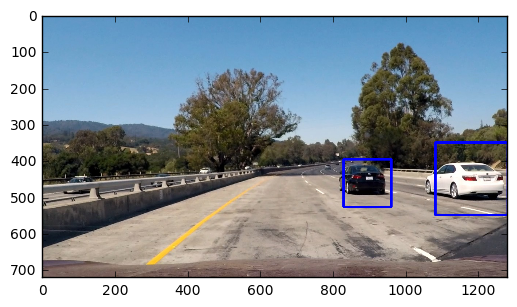

In [5]:
queue = deque([], 5)  
vehicle_array = Vehicle_Array()
image = mpimg.imread('.\\test_images\\test1.jpg')
%matplotlib inline
plt.imshow(detect_vehicle(image, ignore_queue=True))

In [19]:
queue = deque([], 15)  
vehicle_array = Vehicle_Array()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = "project_video__out.mp4"
%matplotlib inline
video_file = VideoFileClip( 'project_video.mp4')
vid = video_file.fl_image(detect_vehicle)
%time vid.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video__out.mp4
[MoviePy] Writing video project_video__out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [22:54<00:01,  1.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video__out.mp4 

Wall time: 22min 55s


In [20]:
counter = 0
def save_file(img):
    global counter
    plt.imsave('test_vid\\img_'+str(counter)+'.jpg',img)
    counter += 1
    return img
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = "test_video_outsdafsdfds_1.mp4"
%matplotlib inline
video_file = VideoFileClip( 'project_video_cut_1.mp4')
vid = video_file.fl_image(save_file)
%time vid.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_video_outsdafsdfds_1.mp4
[MoviePy] Writing video test_video_outsdafsdfds_1.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:18<00:00, 13.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_outsdafsdfds_1.mp4 

Wall time: 19.4 s
